## Initialize the spark

In [1]:
spark

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 6, Finished, Available)

In [2]:
workspace_default_storage_account = "group10astorage46582e02e"
workspace_default_container = "azureml-blobstore-e8a18b52-3288-4d1f-9f32-d5a9249c2c0e"
workspace_wasbs_base_url = (f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 7, Finished, Available)

In [3]:
sub_load = spark.read.parquet(f"{workspace_wasbs_base_url}/mbti_submission.parquet")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 8, Finished, Available)

## Data cleaning for the submission data

In [4]:
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml import Pipeline

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 9, Finished, Available)

In [4]:
sub_load.take(5)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 17, 9, Finished, Available)

[Row(id='ui1lbb', submission_author='Forbidden_Crisp', num_crossposts=0, num_comments=4, submission_score=2, submission_title='Help me type my BF, pls!', submission_created_date=datetime.datetime(2022, 5, 4, 8, 4, 20), submission_year=2022, submission_month=5, mbti_type_related='general'),
 Row(id='ui1nfk', submission_author='Acceptable-Elk2871', num_crossposts=0, num_comments=2, submission_score=2, submission_title='Perfectionism in Ti vs Te users', submission_created_date=datetime.datetime(2022, 5, 4, 8, 9, 2), submission_year=2022, submission_month=5, mbti_type_related='general'),
 Row(id='ui1niz', submission_author='[deleted]', num_crossposts=0, num_comments=8, submission_score=3, submission_title='Which MBTI is most likely to judge someone for being cringe and conform to social norms and pressures?', submission_created_date=datetime.datetime(2022, 5, 4, 8, 9, 18), submission_year=2022, submission_month=5, mbti_type_related='general'),
 Row(id='ui1y0n', submission_author='[deleted]

In [5]:
#convert to lower case
df_cleaned = sub_load.withColumn("cleaned_text", lower(col("submission_title")))
# remove punctuation
df_cleaned = df_cleaned.withColumn("cleaned_text", regexp_replace("cleaned_text", "[^a-zA-Z0-9\\s]", ""))
# remove the rows with na in the cleaned_text column
df_cleaned = df_cleaned.na.drop(subset=["cleaned_text"])

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 10, Finished, Available)

In [6]:
df_cleaned.show(5)

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 11, Finished, Available)

+------+--------------------+--------------+------------+----------------+--------------------+-----------------------+---------------+----------------+-----------------+--------------------+
|    id|   submission_author|num_crossposts|num_comments|submission_score|    submission_title|submission_created_date|submission_year|submission_month|mbti_type_related|        cleaned_text|
+------+--------------------+--------------+------------+----------------+--------------------+-----------------------+---------------+----------------+-----------------+--------------------+
|ui1lbb|     Forbidden_Crisp|             0|           4|               2|Help me type my B...|    2022-05-04 08:04:20|           2022|               5|          general|help me type my b...|
|ui1nfk|  Acceptable-Elk2871|             0|           2|               2|Perfectionism in ...|    2022-05-04 08:09:02|           2022|               5|          general|perfectionism in ...|
|ui1niz|           [deleted]|           

## Build LDA model

Latent Dirichlet Allocation (LDA) is a generative probabilistic model used for topic modeling. Topic modeling is a technique in natural language processing (NLP) that aims to automatically identify topics present in a text corpus. LDA is an unsupervised machine learning approach; it doesn’t need any training data. All it needs is a document-word matrix as input. So in order to have a more concise understanding of the topics discussed in Reddit related to MBTI, we use LDA to build a topic model. The expectation results of the LDA model is seperate topics with specific related topic words in each topic. The topic words in each topic should be related to a same topic. 

In [7]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 12, Finished, Available)

In [8]:
# Step 1: Tokenization (if not done previously)
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Step 2: Remove Stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = stopwords_remover.transform(df_tokenized)

# Step 3: Count Vectorization
count_vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
count_vectorizer_model = count_vectorizer.fit(df_no_stopwords)
df_count_vectorized = count_vectorizer_model.transform(df_no_stopwords)

# Step 4: Term Frequency-Inverse Document Frequency (TF-IDF) transformation
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_count_vectorized)
df_tfidf = idf_model.transform(df_count_vectorized)

# Step 5: Build the LDA model
num_topics = 10
lda = LDA(k=num_topics, maxIter=30, featuresCol="features")

# Step 6: Create a pipeline
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer_model, idf_model, lda])


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 13, Finished, Available)

In [10]:
#Fit the pipeline to the data
lda_model = pipeline.fit(df_cleaned)

# Step 8: Get the topics and associated terms
topics = lda_model.stages[-1].describeTopics()

# Show the topics and associated terms
print("LDA Topics:")
topics.show(truncate=False)

# Step 9: Transform the original DataFrame to include topic distributions
df_lda_result = lda_model.transform(df_cleaned)

# Show the LDA result DataFrame
print("LDA Result DataFrame:")
df_lda_result.select("id", "cleaned_text", "filtered_words", "topicDistribution").show(truncate=False)


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 15, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


LDA Topics:
+-----+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                |termWeights                                                                                                                                                                                                                  |
+-----+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[2, 3, 137, 174, 90, 52, 97, 95, 1, 208]   |[0.0744423300557161, 0.07294913423367373, 0.010344442522794445, 0.008522508212908116, 0.00843736017255386, 0.007764

In [13]:
vocab_list = count_vectorizer_model.vocabulary
topic_list = []
for topic_row in topics.collect():
    topic = topic_row.topic
    indices = topic_row.termIndices
    words = [vocab_list[idx] for idx in indices]
    print(f"Topic {topic}: {', '.join(words)}")
    topic_list.append( [', '.join(words)])


StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 18, Finished, Available)

Topic 0: user, deleted, youre, sensors, dynamics, say, post, confused, mbti, intuitives
Topic 1: isfp, see, true, type, likely, mbti, like, people, using, sound
Topic 2: guess, type, questions, mbti, question, , friends, esfj, isfj, differences
Topic 3: intp, infp, intj, entp, infj, like, im, enfp, know, enfj
Topic 4: , whats, typing, personality, need, type, mbti, thoughts, types, help
Topic 5: likely, intuitive, type, mean, least, judging, 16, personalities, types, mbti
Topic 6: type, mbti, help, results, test, based, think, please, best, guess
Topic 7: love, use, list, tier, mbti, esfp, looking, social, subreddit, type
Topic 8: family, ask, anything, friend, dynamic, make, group, im, assumptions, guess
Topic 9: function, ni, fi, fe, ne, ti, te, explain, se, si


In [12]:
topic_list

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 17, Finished, Available)

[['user, deleted, youre, sensors, dynamics, say, post, confused, mbti, intuitives'],
 ['isfp, see, true, type, likely, mbti, like, people, using, sound'],
 ['guess, type, questions, mbti, question, , friends, esfj, isfj, differences'],
 ['intp, infp, intj, entp, infj, like, im, enfp, know, enfj'],
 [', whats, typing, personality, need, type, mbti, thoughts, types, help'],
 ['likely, intuitive, type, mean, least, judging, 16, personalities, types, mbti'],
 ['type, mbti, help, results, test, based, think, please, best, guess'],
 ['love, use, list, tier, mbti, esfp, looking, social, subreddit, type'],
 ['family, ask, anything, friend, dynamic, make, group, im, assumptions, guess'],
 ['function, ni, fi, fe, ne, ti, te, explain, se, si']]

## Get the topic word df

In [32]:
topics_df = topics.toPandas()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 17, 37, Finished, Available)

In [40]:
topics_df['topic_words']=topic_list

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 17, 45, Finished, Available)

In [41]:
topics_df

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 17, 46, Finished, Available)

,topic,termIndices,termWeights,topic_words
0,0,"[2, 3, 52, 137, 1, 174, 197, 0, 207, 239]","[0.07320158542504128, 0.07172727322817883, 0.0...","[user, deleted, say, youre, mbti, sensors, com..."
1,1,"[28, 90, 45, 10, 0, 6, 66, 1, 177, 5]","[0.02081013886159662, 0.013283495809232574, 0....","[family, dynamics, isfp, likely, type, guess, ..."
2,2,"[63, 115, 0, 84, 1, 164, 173, 181, 258, 216]","[0.012423513347924273, 0.01107218506255657, 0....","[question, questions, type, cant, mbti, others..."
3,3,"[4, 11, 12, 14, 15, 26, 18, 5, 23, 56]","[0.019280942764042887, 0.014848827744335748, 0...","[im, infp, intp, intj, entp, enfp, infj, like,..."
4,4,"[7, 24, 89, 73, 17, 0, 58, 79, 1, 186]","[0.020371140323961326, 0.01957934928970912, 0....","[, whats, typing, thoughts, personality, type,..."
5,5,"[10, 60, 0, 68, 67, 153, 146, 125, 64, 159]","[0.018037807467641283, 0.01749271543819784, 0....","[likely, intuitive, type, enneagram, mean, jud..."
6,6,"[0, 6, 1, 13, 19, 29, 9, 16, 39, 40]","[0.034746055286796224, 0.023926146105273053, 0...","[type, guess, mbti, help, based, results, thin..."
7,7,"[74, 175, 182, 140, 1, 80, 109, 113, 273, 270]","[0.014049877791449988, 0.010470149015412414, 0...","[love, looking, social, infjs, mbti, esfp, acc..."
8,8,"[33, 41, 32, 42, 104, 4, 83, 101, 28, 191]","[0.025304658004601296, 0.02404224370535493, 0....","[ask, anything, make, friend, assumptions, im,..."
9,9,"[27, 47, 43, 50, 53, 61, 85, 76, 75, 48]","[0.015960546167837528, 0.01535442150644144, 0....","[function, ni, fi, fe, ne, ti, explain, te, se..."


## plot the distribution of the topic

In [28]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import ast

In [17]:
# read the topic data
topic = pd.read_csv("../data/csv/topic.csv")
# transfer the data into appropriate format
topic['termIndices'] = topic['termIndices'].apply(lambda x: [int(idx) for idx in x.strip('[]').split()])
topic['termWeights'] = topic['termWeights'].apply(lambda x: [float(weight) for weight in x.strip('[]').replace('\n', '').split()])
topic['topic_words'] = topic['topic_words'].apply(lambda x: ast.literal_eval(x)[0].split(', '))


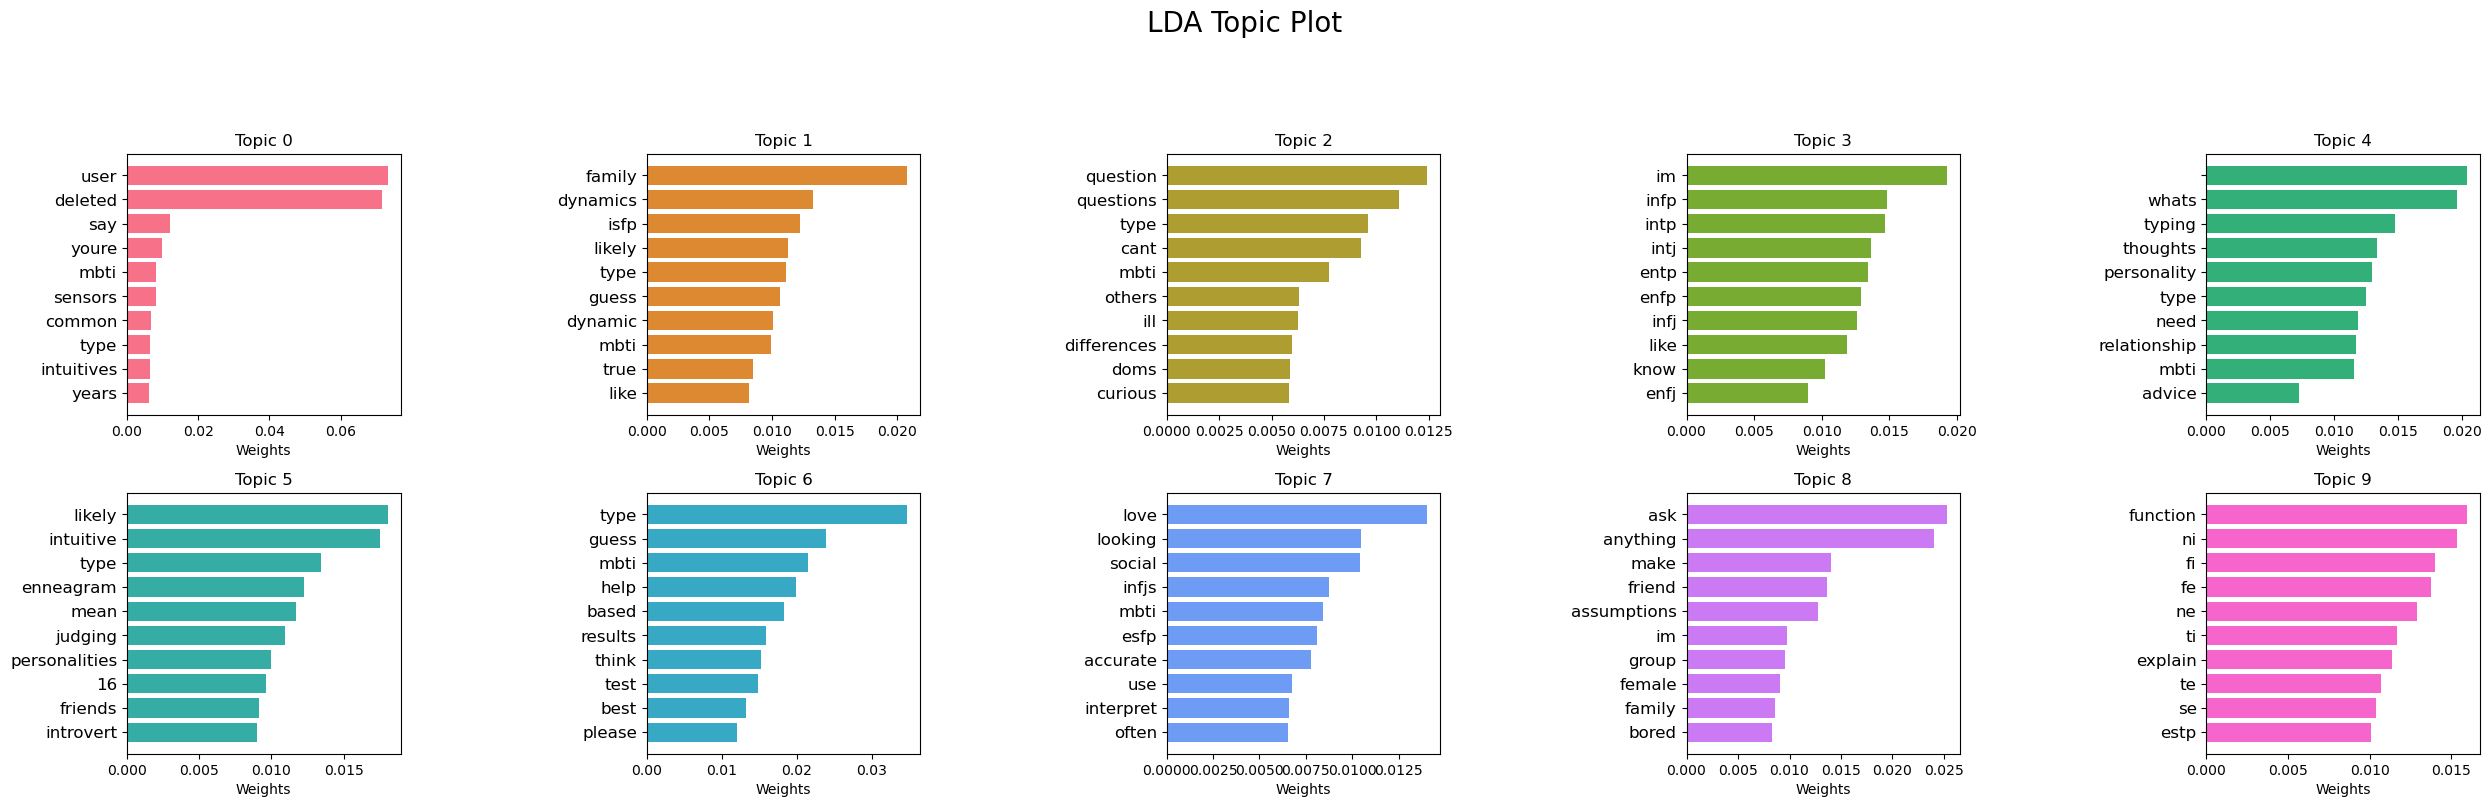

In [34]:
topic_indices = topic['topic']
term_indices = topic['termIndices']
term_weights = topic['termWeights']
topic_words = topic['topic_words']
# Determine the number of rows and columns for the subplot grid
num_topics = len(topic_indices)
num_cols = 5  # Adjust the number of columns as needed
num_rows = int(np.ceil(num_topics / num_cols))
# Create a color palette with a different color for each topic
color_palette = sns.color_palette('husl', n_colors=num_topics)

# Create a figure and axis for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4 * num_rows))

# Loop through each topic and create a subplot
for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        # Get the number of terms
        num_terms = len(term_indices[i])

        # Plot the bar chart
        ax.barh(np.arange(num_terms), term_weights[i], align='center',color=color_palette[i])

        # Set labels and title
        ax.set_yticks(np.arange(num_terms))
        ax.set_yticklabels(topic_words[i],fontdict={'fontsize': 12})
        ax.invert_yaxis()  # To have the highest weight at the top
        ax.set_xlabel('Weights')
        ax.set_title(f'Topic {topic_indices[i]}')
        fig.suptitle("LDA Topic Plot", fontsize=20)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(top=0.80, bottom=0.05, wspace=0.90, hspace=0.3)
plt.savefig('../data/plots/LDA_topic_plot.png', dpi=300)
# Show the plot
plt.show()

The topics inferred from the LDA model reveal intriguing insights into the content of Reddit submissions related to MBTI. Each topic is characterized by a dominant theme, shedding light on the diverse discussions within the community.
- Topic 0: Users Seeking Common Ground
Dominant Word: "User"
Inference: The topic centers around Reddit users aiming for a shared understanding of MBTI types.
- Topic 1: Family Dynamics and MBTI
Dominant Theme: Family
Inference: Discussions delve into the relationships between different MBTI types and their families.
- Topic 2: Questioning the MBTI Universe
Dominant Theme: Questions
Inference: Topics revolve around a variety of questions related to MBTI.
- Topic 3: Personal MBTI Experiences
Dominant Theme: User MBTI Types
Inference: Submissions primarily focus on users sharing their personal MBTI experiences.
- Topic 4: Interpersonal Dynamics Between MBTI Types
Dominant Theme: Relationships
Inference: Conversations explore the dynamics between individuals with different MBTI types.
- Topic 5: Exploring Thoughts and Friendships
Dominant Theme: Thoughts
Inference: Topics touch upon the thoughts of different MBTI types and potentially delve into friendships between them.
- Topic 6: Speculating on MBTI Types
Dominant Theme: Guess
Inference: Discussions and speculations abound regarding guessing the MBTI types of individuals.
- Topic 7: Love Lives and Social Status Across MBTI Types
Dominant Themes: Love, Social Status
Inference: Conversations explore the realms of love lives and social statuses associated with different MBTI types.
- Topic 8: MBTI AMAs (Ask Me Anything)
Dominant Theme: AMA
Inference: Submissions where users inquire about anything related to a specific MBTI type.
- Topic 9: Unpacking Cognitive Functions (N, I, F, T, E)
Dominant Themes: N, I, F, T, E (Cognitive Functions)
Inference: Discussions revolve around understanding the cognitive functions associated with different MBTI types.

## Get the word cloud and important word

#### get the top 5 important words from tf-idf 

In [25]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.linalg import DenseVector
from wordcloud import WordCloud
import matplotlib.pyplot as plt

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 30, Finished, Available)

In [28]:
def extract_top_words(features, vocabulary, n=5):
    top_indices = features.indices[:n]
    top_words = [vocabulary[idx] for idx in top_indices]
    return top_words

# Assuming count_vectorizer_model is the third stage in your pipeline
vocabulary = count_vectorizer_model.vocabulary

# UDF to extract top words
extract_top_words_udf = udf(lambda features: extract_top_words(features, vocabulary), ArrayType(StringType()))

# Applying the UDF to create a new column "top_words"
df_tfidf_with_top_words = df_tfidf.withColumn("top_words", extract_top_words_udf(col("features")))



StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 33, Finished, Available)

In [35]:
df_pandas = df_tfidf_with_top_words.limit(10).toPandas()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 40, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.


In [36]:
df_pandas

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 41, Finished, Available)

,id,submission_author,num_crossposts,num_comments,submission_score,submission_title,submission_created_date,submission_year,submission_month,mbti_type_related,cleaned_text,words,filtered_words,raw_features,features,top_words
0,ui1lbb,Forbidden_Crisp,0,4,2,"Help me type my BF, pls!",2022-05-04 08:04:20,2022,5,general,help me type my bf pls,"[help, me, type, my, bf, pls]","[help, type, bf, pls]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.6591562559198105, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[type, help, pls, bf]"
1,ui1nfk,Acceptable-Elk2871,0,2,2,Perfectionism in Ti vs Te users,2022-05-04 08:09:02,2022,5,general,perfectionism in ti vs te users,"[perfectionism, in, ti, vs, te, users]","[perfectionism, ti, vs, te, users]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[vs, ti, te, users, perfectionism]"
2,ui1niz,[deleted],0,8,3,Which MBTI is most likely to judge someone for...,2022-05-04 08:09:18,2022,5,general,which mbti is most likely to judge someone for...,"[which, mbti, is, most, likely, to, judge, som...","[mbti, likely, judge, someone, cringe, conform...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0883185220781857, 0.0, 0.0, 0.0, 0.0, ...","[mbti, likely, someone, social, judge]"
3,ui1y0n,[deleted],0,7,1,Would this be a function?,2022-05-04 08:32:10,2022,5,general,would this be a function,"[would, this, be, a, function]",[function],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[function]
4,ui20u9,Glittering-Corgi-557,0,36,1,is Ni possible without hunches,2022-05-04 08:38:12,2022,5,general,is ni possible without hunches,"[is, ni, possible, without, hunches]","[ni, possible, without, hunches]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[ni, possible, without, hunches]"
5,ui257n,[deleted],0,8,20,"Found this visual to be accurate, what do you ...",2022-05-04 08:47:57,2022,5,general,found this visual to be accurate what do you t...,"[found, this, visual, to, be, accurate, what, ...","[found, visual, accurate, think]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[think, accurate, found, visual]"
6,ui2awf,night-laughs,0,1,1,Can underdeveloped inferior Si affect how domi...,2022-05-04 09:00:38,2022,5,general,can underdeveloped inferior si affect how domi...,"[can, underdeveloped, inferior, si, affect, ho...","[underdeveloped, inferior, si, affect, dominan...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[ne, si, inferior, dominant, affect]"
7,xtdg3q,verovatno_fed,0,1,2,Voting,2022-10-02 02:45:48,2022,10,general,voting,[voting],[voting],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[voting]
8,xtdxzm,ApaixonadapeloEren,0,0,1,MOST TO LEAST ATTRACTIVE TYPES (I'm a ISTP),2022-10-02 03:11:50,2022,10,ISTP,most to least attractive types im a istp,"[most, to, least, attractive, types, im, a, istp]","[least, attractive, types, im, istp]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 0.0, 3.0122448217188453, 0.0, ...","[im, types, istp, least, attractive]"
9,xtdzkx,[deleted],0,3,0,which mbti is the most likely to steal food fr...,2022-10-02 03:14:07,2022,10,general,which mbti is the most likely to steal food fr...,"[which, mbti, is, the, most, likely, to, steal...","[mbti, likely, steal, food, someone, shared, f...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 2.0883185220781857, 0.0, 0.0, 0.0, 0.0, ...","[mbti, likely, someone, food, steal]"


In [37]:
df_pandas.to_csv("Users/xl659/fall-2023-reddit-project-team-10/data/csv/tf_idf.csv")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 42, Finished, Available)

In [38]:
df_cleaned_pandas = df_cleaned.select("cleaned_text").toPandas()

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 43, Finished, Available)

In [39]:
df_cleaned_pandas.to_csv("Users/xl659/fall-2023-reddit-project-team-10/data/csv/cleaned_text.csv")

StatementMeta(80dcc4b2-bc50-4e81-91e5-397b7f13252e, 20, 44, Finished, Available)

## The important word of the Tf-idf dataframe

In [21]:
df_tfidf = pd.read_csv("../data/csv/tf_idf.csv")

In [24]:
df_tfidf_sub = df_tfidf[['submission_title','cleaned_text','top_words']]

In [25]:
df_tfidf_sub

,submission_title,cleaned_text,top_words
0,"Help me type my BF, pls!",help me type my bf pls,"['type', 'help', 'pls', 'bf']"
1,Perfectionism in Ti vs Te users,perfectionism in ti vs te users,"['vs', 'ti', 'te', 'users', 'perfectionism']"
2,Which MBTI is most likely to judge someone for...,which mbti is most likely to judge someone for...,"['mbti', 'likely', 'someone', 'social', 'judge']"
3,Would this be a function?,would this be a function,['function']
4,is Ni possible without hunches,is ni possible without hunches,"['ni', 'possible', 'without', 'hunches']"
5,"Found this visual to be accurate, what do you ...",found this visual to be accurate what do you t...,"['think', 'accurate', 'found', 'visual']"
6,Can underdeveloped inferior Si affect how domi...,can underdeveloped inferior si affect how domi...,"['ne', 'si', 'inferior', 'dominant', 'affect']"
7,Voting,voting,['voting']
8,MOST TO LEAST ATTRACTIVE TYPES (I'm a ISTP),most to least attractive types im a istp,"['im', 'types', 'istp', 'least', 'attractive']"
9,which mbti is the most likely to steal food fr...,which mbti is the most likely to steal food fr...,"['mbti', 'likely', 'someone', 'food', 'steal']"


Term Frequency-Inverse Document Frequency (TF-IDF) is a crucial concept in natural language processing and information retrieval. It serves as a numerical statistic that reflects the significance of a term within a collection of documents. TF-IDF is calculated by combining two metrics: Term Frequency (TF), representing the frequency of a term within a specific document, and Inverse Document Frequency (IDF), measuring the rarity of the term across the entire document set. For each submission, the top 5 important words are selected from the tf-idf dataframe. We use the first 10 rows as an example. We can see that based on the top words in each row, type, mbti and think are important words in the submission.

## Plot the word cloud

In [2]:
df_cleaned = pd.read_csv("../data/csv/cleaned_text.csv")

In [35]:
df_cleaned['cleaned_text'].head()

0                               help me type my bf pls
1                      perfectionism in ti vs te users
2    which mbti is most likely to judge someone for...
3                             would this be a function
4                       is ni possible without hunches
Name: cleaned_text, dtype: object

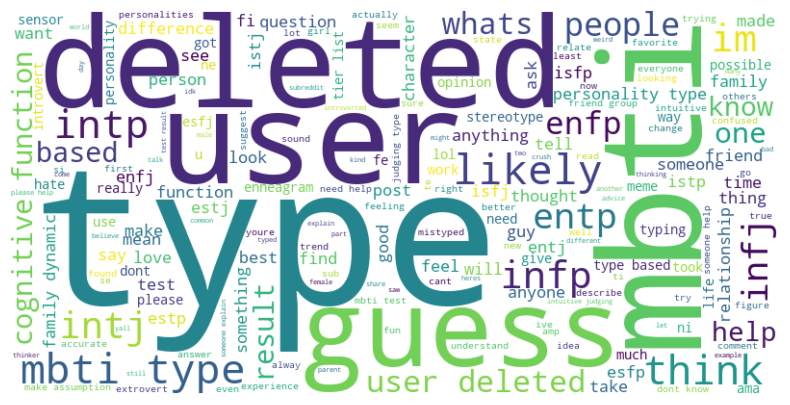

In [26]:
df_cleaned["cleaned_text"] = df_cleaned["cleaned_text"].astype(str)
text = " ".join(df_cleaned["cleaned_text"])

# Generate a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/plots/submission_wordcloud.png")
plt.show()

In order to understand the most common words that exist in the Reddit submissions related to MBTI, we could use the wordcloud to get the word frequency in all the submissions. From the wordcloud above, we can see that in the MBTI related submission titles, the most frequent words are "type", "personality", "mbti'. It is reasonable to have these words in MBTI related Reddit posts. Besides, the basic information of the MBTI types are also frequently mentioned in the titles, such as "intj", "enfp", "infj", "entp", "intp", "enfj", "istp", "istj", "entj", "isfp", "infp", "estp", "isfj", "estj", "esfp", "esfj".We may infer that Reddit users like to post submissions to ask what people think about their MBTI types and guess what the MBTI types of others are. 